In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import mode,zscore
from matplotlib import pyplot as plt


data = pd.read_json("../../../data.json")
data["iqs"] = data["iq"].map(lambda x: [x[i:i+6] for i in range(16,len(x),6)][:-1]) 

data.sample(2)

,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1,iqs
14519,43,c300000a7a46,2024-11-10 18:01:27.132000+00:00,0,-64,0201061bff3906cafb01140007ffd50107000000000000...,2402,"[83, 153, -174, 35, 2, -186, 188, 26, -45, 179...",30,600.0,camila,"[1.0737421275, 2.9430921218, -1.560044053, 0.1...","[2.3220869874, 0.149608984, -2.2108252273, 2.0...","[-2.687911492, 1.3297430606, -0.8169063571, -2...","[-1.4641909473, 2.6696119041, 0.3365054427, -1...","[1.2731868277, 1.1801340766, 1.3939188702, 1.3...","[1.2237205447, 1.3398688436000001, 1.153411799...","[2.4969073724, 2.5200029202, 2.54733067, 2.602...","[[-184, 197, -242, -118, 29, -271], [272, 41, ..."
17605,114,c300000a7a46,2024-11-10 17:25:14.269000+00:00,0,-71,0201061bff3906cafb0114fbffefff0701000000000000...,2480,"[19, 155, -162, -23, 60, -159, 132, 74, -81, 1...",90,1200.0,camila,"[1.4488241713, -3.000559903, -1.2099595438, 0....","[-1.9908208344, 1.9974238199, -0.1441543871, -...","[1.4749371797, -0.8086497862, -2.9267772532, 1...","[-0.5260664190000001, -2.8345469216, 1.4677147...","[-2.817427293, -2.8060736061, -2.7826228661, -...","[-2.0010035987, -2.0258971354, -1.888693335700...","[1.4647544155, 1.4512145657, 1.6118691054, 1.4...","[[-46, -103, 5, 52, 31, -18], [-45, 99, 42, -4..."


# PD in each line and Post-Filtering

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error,mean_squared_error

tsamples =[]
tlabels =[]

vsamples=[]
vlabels=[]

tdataset, vdataset = train_test_split(data[data["capture"]== "tw"],test_size=0.2)

for row in tdataset.iterrows():
    for element in row[1]["iqs"]:
        tsamples.append(element)
        tlabels.append(row[1]["angle"])

for row in vdataset.iterrows():
    for element in row[1]["iqs"]:
        vsamples.append(element)
        vlabels.append(row[1]["angle"])

X_train = tsamples
y_train = tlabels#[label//15 for label in tlabels ]

X_test = vsamples
y_test = vlabels #[label//15 for label in vlabels ]


#array_names= ([str(name) for name in range(0,180+15,15)])

In [21]:

#Splitting the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Creating an XGBoost classifier
model = xgb.XGBRegressor(enable_categorical=True)

#Training the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
mae =mean_absolute_error(y_test, predictions)
mse =mean_squared_error(y_test, predictions)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=6.83062756339167

mse=107.16198363912002



In [23]:
results_labels= []
results_values = []
for row in vdataset.iterrows():
    pred=[]
    for element in row[1]["iqs"]:
        pred.append(model.predict([element])[0])
    results_labels.append((row[1]["angle"]))
    results_values.append(np.mean(pred))

In [24]:
#Calculating accuracy
mae =mean_absolute_error(results_labels, results_values)
mse =mean_squared_error(results_labels, results_values)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=4.616118726044357

mse=49.37006385302785



In [25]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for element in row[1]["iqs"]:
        pred.append(model.predict([element])[0])
    results[str(row[1]["angle"])].append(np.mean(pred))

In [26]:
# for key, values in results.items():
#     print(f"Angulo {key}\n" )
#     print(f"\t media = {np.mean(values)} \t std = {np.std(values)} \t variance ={np.var(values)} ")

In [ ]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


SyntaxError: f-string: single '}' is not allowed (2873414357.py, line 15)

In [ ]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    pred = np.array(pred)

    pred = pred[zscore(pred)<2]
    results[str(row[1]["angle"])].append(np.mean(pred))
    

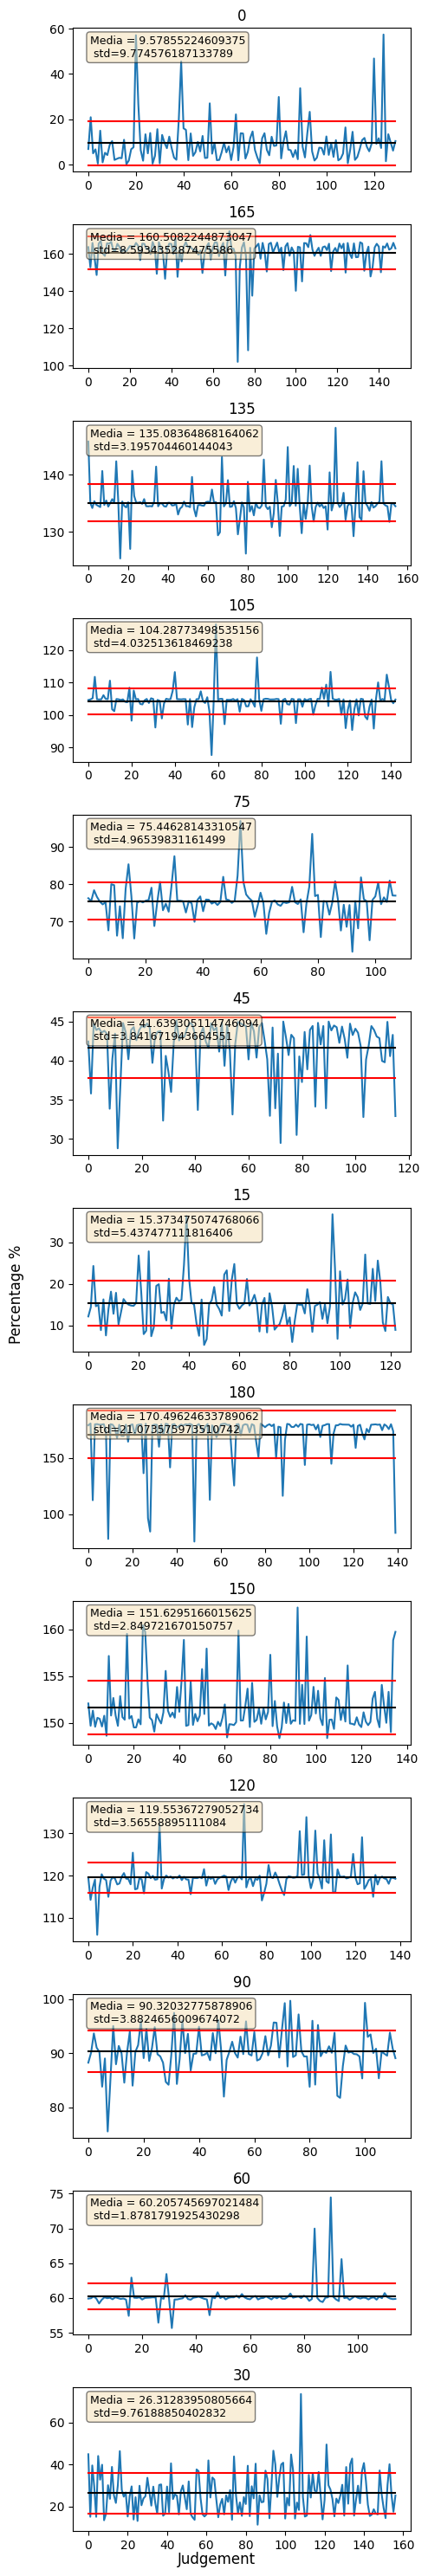

In [ ]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


In [ ]:
model.save_model("./xbg_regressor.json")